This notebook extracts and plot simulated main meteorological data

In [1]:
#import modules
%run ../load_main.py
import wrf
import salem
import datetime
import warnings
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp
from Air_Quality_notebooks import utils as utl

WRFchem outputs data path is: dpath=/geos/d21/s1878599/IGP


### Load data 

In [2]:
#Get IGP data for each season
aut_pth=dpath +'/outputs/autumn/wrfout*.nc'
win_pth=dpath +'/outputs/winter/wrfout*.nc'
mon_pth=dpath +'/outputs/monsoon/wrfout*.nc'
pmon_pth=dpath +'/outputs/premonsoon/wrfout*.nc'

shp_path =  '/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp'

#get IGP data only
aIGP =igp.get_IGP(aut_pth, shp_path)
wIGP =igp.get_IGP(win_pth, shp_path)
mIGP =igp.get_IGP(mon_pth, shp_path)
pmIGP =igp.get_IGP(pmon_pth, shp_path)

### Extract  T, PBLH, RAIN, WIND, RH

In [3]:
# get Temperature in Celsius
def calc_tc(d):
    for v in d.values():
        v["T2_c"]= v["T2"]- 273.15
    
calc_tc(aIGP)
calc_tc(wIGP)
calc_tc(pmIGP)
calc_tc(mIGP)

In [4]:
# get Rain production
def calc_totrain(ds):
    # following formula userguide v04 
    bucket_mm=100
    ds["RAINTOT"]=ds.RAINC + bucket_mm*ds.I_RAINC + ds.RAINNC + bucket_mm*ds.I_RAINNC
    ds["RAINTOT"]=ds["RAINTOT"][len(ds.Time)-1,:,:] #get only lsat value (accumulated)

def calc_tr(d):
    for v in d.values():
        calc_totrain(v)

calc_tr(aIGP)
calc_tr(wIGP)
calc_tr(pmIGP)
calc_tr(mIGP)

In [5]:
# get wind speed
def calc_windspeed(d):
    for v in d.values():
        v["WS10"]= (v.U10 ** 2 + v.V10 ** 2) ** 0.5

calc_windspeed(aIGP)
calc_windspeed(wIGP)
calc_windspeed(pmIGP)
calc_windspeed(mIGP)

In [6]:
# get noon and midnight values of pblh.

def pblh_noon_mid(d):
    p0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    p12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    for k,v in d.items():
        p12[k]=v.PBLH.sel(Time=v.PBLH.Time.dt.hour.isin(12))
        p0[k]=v.PBLH.sel(Time=v.PBLH.Time.dt.hour.isin(0))
    return p0,p12
        
ap0,ap12=pblh_noon_mid(aIGP)
wp0,wp12=pblh_noon_mid(wIGP)
pmp0,pmp12=pblh_noon_mid(pmIGP)
mp0,mp12=pblh_noon_mid(mIGP)

In [7]:
#get noon and midnight surface relative humidity

def calc_surf_rh(ds):
# formula at: https://mailman.ucar.edu/pipermail/wrf-users/2012/002546.html
    pq0 = 379.90516
    a2 = 17.2693882
    a3 = 273.16
    a4 = 35.86
    ds['surf_RH'] = ds.Q2 * 100 / ( (pq0 / ds.PSFC) * np.exp(a2 * (ds.T2 - a3) / (ds.T2 - a4)))


def rh_noon_mid(d):
    rh0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    rh12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    for k,v in d.items():
        calc_surf_rh(d[k])
        rh12[k]=v.surf_RH.sel(Time=v.surf_RH.Time.dt.hour.isin(12))
        rh0[k]=v.surf_RH.sel(Time=v.surf_RH.Time.dt.hour.isin(0))
    return rh0,rh12
        
arh0,arh12=rh_noon_mid(aIGP)
wrh0,wrh12=rh_noon_mid(wIGP)
pmrh0,pmrh12=rh_noon_mid(pmIGP)
mrh0,mrh12=rh_noon_mid(mIGP)        

In [8]:
#time space average values for Temperature, Wind Rain.
def get_tsm_IGP(d,tname):
    tsaer_IGP={}
    for adm, val in d.items():
        tsaer_IGP.update({adm : st.space_mean(st.time_mean(val,tname))})
    return tsaer_IGP

a= get_tsm_IGP(aIGP,"Time")
w= get_tsm_IGP(wIGP,"Time")
m= get_tsm_IGP(mIGP,"Time")
pm= get_tsm_IGP(pmIGP,"Time")

In [9]:
# time and space average for noon and midnight PBLH 
def pblh_ts(p0,p12):
    tsp0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    tsp12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
   
    for k in p0.keys():
        tsp12[k]=p12[k].mean(['Time','south_north','west_east'])
        tsp0[k]=p0[k].mean(['Time','south_north','west_east'])
    return tsp0,tsp12
        
ats_p0,ats_p12=pblh_ts(ap0,ap12)
wts_p0,wts_p12=pblh_ts(wp0,wp12)
pmts_p0,pmts_p12=pblh_ts(pmp0,pmp12)
mts_p0,mts_p12=pblh_ts(mp0,mp12)

In [10]:
# time and space average for noon and midnight RH
def rh_ts(rh0,rh12):
    tsrh0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    tsrh12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
   
    for k in rh0.keys():
        tsrh12[k]=rh12[k].mean(['Time','south_north','west_east'])
        tsrh0[k]=rh0[k].mean(['Time','south_north','west_east'])
    return tsrh0,tsrh12
        
ats_rh0,ats_rh12=rh_ts(arh0,arh12)
wts_rh0,wts_rh12=rh_ts(wrh0,wrh12)
pmts_rh0,pmts_rh12=rh_ts(pmrh0,pmrh12)
mts_rh0,mts_rh12=rh_ts(mrh0,mrh12)

In [11]:
#GET VARIABLES VALUES

def get_val(d, vname,special=False):
    r={}
    for adm, val in d.items():
        if special==True:
            r.update({adm : val.values})  # special handles RH and PBLH that are not dataset but dataarray.
        else:   
            r.update({adm : val[vname].values})
    return r

#surface temperature
atemp = get_val(a,"T2_c")
wtemp = get_val(w,"T2_c")
pmtemp= get_val(pm,"T2_c")
mtemp = get_val(m,"T2_c")

#get RAIN
atr = get_val(a,"RAINTOT")
wtr = get_val(w,"RAINTOT")
pmr= get_val(pm,"RAINTOT")
mtr = get_val(m,"RAINTOT")

#get WSPEED at 10m
atw = get_val(a,"WS10")
wtw = get_val(w,"WS10")
pmw= get_val(pm,"WS10")
mtw = get_val(m,"WS10")
                                                                           
#get PBLH 12 (noon)
atpb12 = get_val(ats_p12,"PBLH",True)
wtpb12 = get_val(wts_p12,"PBLH",True)
pmtpb12= get_val(pmts_p12,"PBLH",True)
mtpb12 = get_val(mts_p12,"PBLH",True)

#get PBLH 0 (midnight)
atpb0 = get_val(ats_p0,"PBLH",True)
wtpb0 = get_val(wts_p0,"PBLH",True)
pmtpb0 = get_val(pmts_p0,"PBLH",True)
mtpb0 = get_val(mts_p0,"PBLH",True)

#get rh 12 (noon)
atrh12 = get_val(ats_rh12,"PBLH",True)
wtrh12 = get_val(wts_rh12,"PBLH",True)
pmtrh12= get_val(pmts_rh12,"PBLH",True)
mtrh12 = get_val(mts_rh12,"PBLH",True)

#get rh 0 (midnight)
atrh0 = get_val(ats_rh0,"PBLH",True)
wtrh0 = get_val(wts_rh0,"PBLH",True)
pmtrh0 = get_val(pmts_rh0,"PBLH",True)
mtrh0 = get_val(mts_rh0,"PBLH",True)

### bar plots by IGP subregion

In [12]:
#define plot function
import plotly.graph_objects as go
def plot_bars(pm,m,a,w,title,colors,ylabel="Celsius",sf=1):

    data = {
    "upper":[pm["U_IGP"]*sf,m["U_IGP"]*sf,a["U_IGP"]*sf,w["U_IGP"]*sf],
    "middle":[pm["M_IGP"]*sf,m["M_IGP"]*sf,a["M_IGP"]*sf,w["M_IGP"]*sf],
    "lower": [pm["L_IGP"]*sf,m["L_IGP"]*sf,a["L_IGP"]*sf,w["L_IGP"]*sf],
    "labels": [
        "Premonsoon",
        "Monsoon",
        "Autumn",
        "Winter",
    ]
    }

    fig = go.Figure(
    data=[
        go.Bar(
            name="Upper IGP",
            x=data["labels"],
            y=data["upper"],
            marker_color=colors[0],            
            offsetgroup=0,
        ),
        go.Bar(
            name="Middle IGP",
            x=data["labels"],
            y=data["middle"],
             marker_color= colors[1], 
            offsetgroup=1,
        ),
        go.Bar(
            name="Lower IGP",
            x=data["labels"],
            y=data["lower"],
            marker_color=colors[2],
            offsetgroup=2,
        )
    ],
    layout=go.Layout(
        title_text=title, title_x=0.5,
        yaxis_title=ylabel
    )
    )

    fig.show()

In [13]:
col=["rgb(153,0,0)","rgb(255,0,0)","rgb(255,102,102)"]
plot_bars(pmtemp,mtemp,atemp,wtemp, colors=col, ylabel="Celsius", title="T (2m)")

In [14]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmtpb12,mtpb12,atpb12,wtpb12, colors=col, ylabel="meters", title="PBLH noon")

In [15]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmtpb0,mtpb0,atpb0,wtpb0, colors=col, ylabel="meters", title="PBLH midnight")

In [16]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmr,mtr,atr,wtr, colors=col, ylabel="mm", title="RAIN (mm)")

In [17]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmtrh0,mtrh0,atrh0,wtrh0, colors=col, ylabel="%", title="RH midnight")

In [18]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmtrh12,mtrh12,atrh12,wtrh12, colors=col, ylabel="%", title="RH noon")

In [19]:
col=["rgb(0,0,255)","rgb(51,153,255)", "rgb(102,255,255)"]
plot_bars(pmw,mtw,atw,wtw, colors=col, ylabel="m s-1", title="WIND SPEED AT (10m)")

## Spatial plots

In [20]:
#Get data time average values Temeprature, Rain, Wind
def get_tm_IGP(d,tname):
    taer_IGP={}
    for adm, val in d.items():
        taer_IGP.update({adm : st.time_mean(val,tname)})
    return taer_IGP

at= get_tm_IGP(aIGP,"Time")
wt= get_tm_IGP(wIGP,"Time")
mt= get_tm_IGP(mIGP,"Time")
pmt= get_tm_IGP(pmIGP,"Time")

In [21]:
# PBLH time average for noon and midnight
def pblh_t(p0,p12):
    tp0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    tp12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
   
    for k in p0.keys():
        tp12[k]=p12[k].mean(['Time'])
        tp0[k]=p0[k].mean(['Time'])
    return tp0,tp12
        
at_p0,at_p12=pblh_t(ap0,ap12)
wt_p0,wt_p12=pblh_t(wp0,wp12)
pmt_p0,pmt_p12=pblh_t(pmp0,pmp12)
mt_p0,mt_p12=pblh_t(mp0,mp12)

In [22]:
# RH time average for noon and midnight
def rh_t(rh0,rh12):
    trh0={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
    trh12={'IGP':None, 'U_IGP':None,'M_IGP':None, 'L_IGP':None}
   
    for k in rh0.keys():
        trh12[k]=rh12[k].mean(['Time'])
        trh0[k]=rh0[k].mean(['Time'])
    return trh0,trh12
        
at_rh0,at_rh12=rh_t(arh0,arh12)
wt_rh0,wt_rh12=rh_t(wrh0,wrh12)
pmt_rh0,pmt_rh12=rh_t(pmrh0,pmrh12)
mt_rh0,mt_rh12=rh_t(mrh0,mrh12)

In [23]:
#define plot function for a variable (wind excluded)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        gl.xlocator = mticker.FixedLocator([70,80,90])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.3)
        ax.add_feature(cfeature.BORDERS, lw=0.3)
        
        gl.yformatter = LATITUDE_FORMATTER
        gl.xformatter = LONGITUDE_FORMATTER
        gl.ylabel_style = {'size': 11, 'color': 'grey'} 
    
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
            gl.xlabel_style = {'size': 11, 'color': 'grey'}
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.8, lw=0.5)
            

            
def meteoplot(lat,lon,pmds,mds,ads,wds, title=None, label=None, cmap="OrRd", vmin=0,vmax=None,levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,delta=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values
    vm= mds[:,:].values
    va= ads[:,:].values
    vw= wds[:,:].values
   
    if vmax is None:
        import math                # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max()        
    
    vmin=vmin
    print(vmax,vmin)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customised. 
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax, extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')                                              
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax, extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax, extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, vmin=vmin,vmax=vmax, extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')
    
    #000099#00007f#000066
    
    #add season labels
   
    axes[0].text(-0.2, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[0].transAxes)
    axes[1].text(-0.2, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[1].transAxes)
    axes[2].text(-0.2, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[2].transAxes)
    axes[3].text(-0.2, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[3].transAxes)
   
    
    cbar_ax = fig.add_axes([0.8, 0.15, 0.04, 0.7])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.1,shrink=0.5, format=format)
    cbar.set_label(label,fontsize=14)
    cbar.ax.tick_params(labelsize='medium')

    #reshape spacing between ticks
    if delta is None:
            delta=int(vmax/10)
            cbar.set_ticks(list(range(vmin, vmax+delta, delta)))
            cbar.set_ticklabels(list(range(vmin, vmax, delta))+[vmax])
    
    #title
    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi,bbox_inches = "tight")
    
    fig.show()

In [24]:
#define lat lon for plotting 
lon =at["IGP"].XLONG.values[0,:,:]
lat =at["IGP"].XLAT.values[0,:,:]

#path to save plots
savepth='./'

40 0


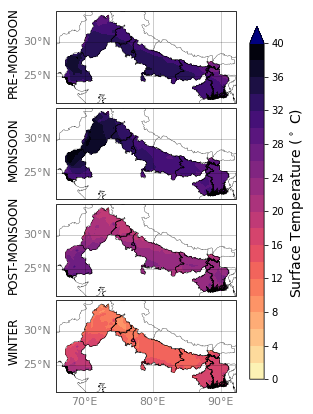

In [25]:
#temperature
meteoplot(lat,lon,pmt["IGP"].T2_c,mt["IGP"].T2_c,at["IGP"].T2_c,wt["IGP"].T2_c,cmap="magma_r",vmin=0,vmax=40, label="Surface Temperature ($^\circ~$C)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name='temp',savef='png', dpi=300)

1200 0


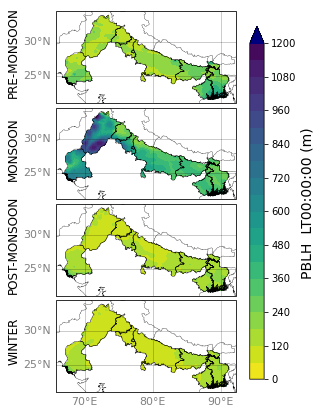

In [26]:
#PBLH at midnight
meteoplot(lat,lon,pmt_p0["IGP"],mt_p0["IGP"],at_p0["IGP"],wt_p0["IGP"],cmap="viridis_r",vmin=0,vmax=1200, label="PBLH  LT00:00:00 (m)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name="plbh_midnight",savef='png', dpi=300)

4500 0


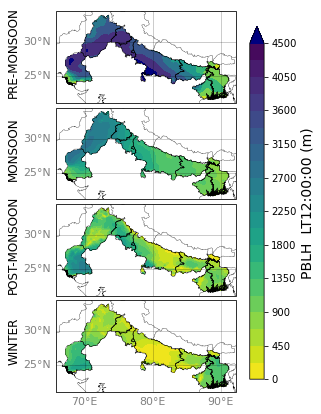

In [27]:
#PBLH at noon
meteoplot(lat,lon,pmt_p12["IGP"],mt_p12["IGP"],at_p12["IGP"],wt_p12["IGP"],cmap="viridis_r",vmin=0,vmax=4500, label="PBLH  LT12:00:00 (m)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name="plbh_noon",savef='png', dpi=300)

100 0


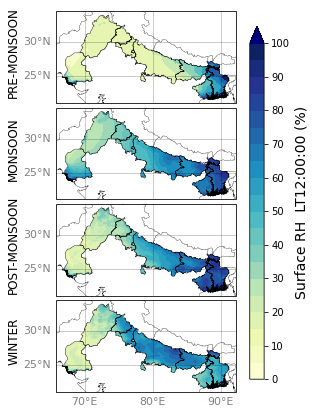

In [28]:
#RH at noon
meteoplot(lat,lon,pmt_rh12["IGP"],mt_rh12["IGP"],at_rh12["IGP"],wt_rh12["IGP"],cmap="YlGnBu",vmin=0,vmax=100, label="Surface RH  LT12:00:00 (%)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name="rh_noon",savef='png', dpi=300)

100 0


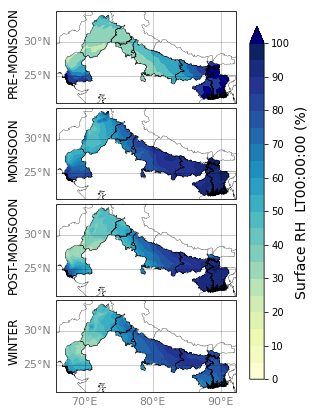

In [29]:
#RH at midnight
meteoplot(lat,lon,pmt_rh0["IGP"],mt_rh0["IGP"],at_rh0["IGP"],wt_rh0["IGP"],cmap="YlGnBu",vmin=0,vmax=100, label="Surface RH  LT00:00:00 (%)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name="rh_midnight",savef='png', dpi=300)

10 0


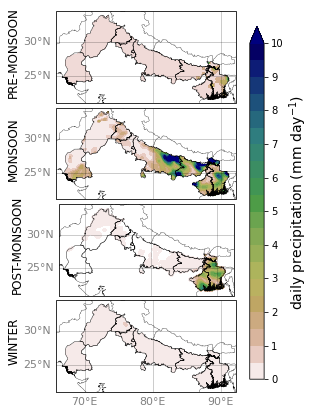

In [30]:
at["IGP"].RAINTOT.values= np.nan_to_num(at["IGP"].RAINTOT.values, copy=False,nan=0.0, posinf=0.0, neginf=0.0)
meteoplot(lat,lon,pmt["IGP"].RAINTOT/28,mt["IGP"].RAINTOT/28,at["IGP"].RAINTOT/29,wt["IGP"].RAINTOT/28,cmap="gist_earth_r",vmin=0,vmax=10, label="daily precipitation (mm day$^{-1}$)", 
        levs=21,figsize=[5,7],format="%.f",save=True, spath=savepth,name='rain',savef='png', dpi=300)

In [31]:
#define plot function for wind

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

import iris
import iris.coord_categorisation

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.xlocator = mticker.FixedLocator([70,80,90])
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
        ax.add_feature(cfeature.BORDERS, lw=0.5)
        

        gl.yformatter = LATITUDE_FORMATTER
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size': 11, 'color': 'grey'}
        gl.ylabel_style = {'size': 11, 'color': 'grey'} 
          # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
    
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.5)

    
def calc_wspeed(ds):
        u = ds.U10[:,:].values
        v = ds.V10[:,:].values
        wspeed = (u ** 2 + v ** 2) ** 0.5
        return wspeed


def windplot(lat,lon,pmds,mds,ads,wds,vmax=None, title=None, label=None, cmap="YlGnBu",delta=None, vmin=0,levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    transform = ccrs.PlateCarree()
    

    #Getting wspeed values.
    vpm=calc_wspeed(pmds)
    vm= calc_wspeed(mds)
    va= calc_wspeed(ads)
    vw= calc_wspeed(wds)
    
    #sampled values for arrows
    spm=pmds[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}]
    sm=mds[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}]
    sa=ads[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}]
    sw=wds[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}]
    lats = pmds.XLAT[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}].values[0,:,:]
    lons = pmds.XLONG[{'south_north': slice(None, None, 5), 'west_east': slice(None, None,5)}].values[0,:,:]
   
    #normalise values
    upms = spm.U10[:,:].values
    vpms = spm.V10[:,:].values
    upms_n = upms/np.sqrt(upms**2.0+vpms**2.0)
    vpms_n = vpms/np.sqrt(upms**2.0+vpms**2.0)

    ums = sm.U10[:,:].values
    vms = sm.V10[:,:].values
    ums_n = ums/np.sqrt(ums**2.0+vms**2.0)
    vms_n = vms/np.sqrt(ums**2.0+vms**2.0)
    uas = sa.U10[:,:].values
    vas = sa.V10[:,:].values
    uas_n = uas/np.sqrt(uas**2.0+vas**2.0)
    vas_n = vas/np.sqrt(upms**2.0+vas**2.0)
    uws = sw.U10[:,:].values
    vws = sw.V10[:,:].values
    uws_n = uws/np.sqrt(uws**2.0+vws**2.0)
    vws_n = vws/np.sqrt(uws**2.0+vws**2.0)
                         

    # Get the max value in the array to plot if not pro
    if vmax is None:
        import math                
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max()        
    vmin=vmin
    print(vmax,vmin)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customised. 
    
    
    # Plot the wind speed as a contour plot and Add arrows to show the wind vectors (quiver)
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,zorder=1,extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')                                              
    axes[0].quiver(lons, lats, upms_n, vpms_n, pivot='middle',zorder=1)                                            
    
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')                                              
    axes[1].quiver(lons, lats, ums_n, vms_n, pivot='middle',transform=transform,scale=40)
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels,vmin=vmin,vmax=vmax,zorder=1,extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')                                              
    axes[2].quiver(lons, lats, uas_n, vas_n, pivot='middle', transform=transform,scale=40,zorder=1) 
    #winter 
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, vmin=vmin,vmax=vmax,extend="max")
    cspm.cmap.set_under('#FFFFFF')
    cspm.cmap.set_over('#00007f')                                              
    axes[3].quiver(lons, lats, uws_n, vws_n, pivot='middle', transform=transform,scale=40)  
    
 
    axes[0].text(-0.2, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[0].transAxes)
    axes[1].text(-0.2, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[1].transAxes)
    axes[2].text(-0.2, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[2].transAxes)
    axes[3].text(-0.2, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=12,
        transform=axes[3].transAxes)
    
    #colorbar
    cbar_ax = fig.add_axes([0.71, 0.15, 0.025, 0.7])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0,shrink=0.5, format=format)
    cbar.set_label(label,fontsize=13)
    cbar.ax.tick_params(labelsize='medium')
    
    #reshape spacing between ticks
    if delta is None:
            delta=0.5
            cbar.set_ticks(list(np.arange(vmin, vmax+delta, delta)))
            #cbar.set_ticklabels(list(range(vmin, vmax, delta))+[vmax])
    

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi,bbox_inches = "tight")
    
    fig.show()

5 0


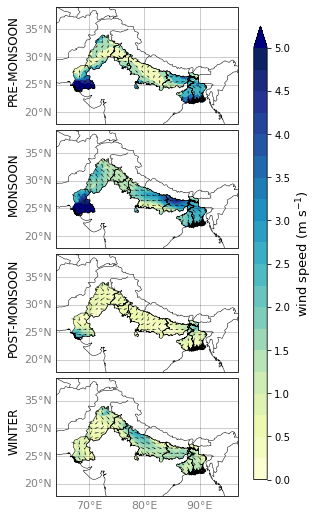

In [32]:
windplot(lat,lon,pmt["IGP"],mt["IGP"],at["IGP"],wt["IGP"],cmap="YlGnBu",vmin=0,vmax=5, label="wind speed (m s$^{-1}$)", 
        levs=21,figsize=[7.5,9],format="%.1f",save=True, spath=savepth,name="wind",savef='png', dpi=300)